In [1]:
import os #Fournit un moyen portable d'utiliser certaines fonctionnalites dependantes de Windows
import numpy as np #Utilisee pour le calcul numerique et la manipulation de tableaux multidimensionnels
import matplotlib.pyplot as plt #Creation de graphiques et de visualisations comme matlab
from matplotlib.patches import Polygon #Creation de graphiques et de visualisations comme matlab
from scipy.ndimage import gaussian_filter as smooth
import gc
from IPython.display import clear_output
import glob
import pandas as pd
from own_Functions import *
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
from median_thomas import *


RESOLUTION=[512,512]
REMAINING_REWARDS = False # if true, indicate the number of reward available on an object when the mouse starts to go around
MINIMAL_DURATION_STOP = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
MINIMAL_DURATION_EPOCH = 0.3 #minimal duration of an epoch to be considerd
TRUE_SIGMA = 1 #the sigma used for the remaining of the analysis
TRUE_CUT_SPEED = 7 #value to be used for the remaining of the analysis
TRUE_ECART_ANGLE = 1 #if a change is made, must change timeofframes
TRAPEZE_SIZE = 35 #how much to extend outside of the objects to detect the trajectories

#Defines the coordinates of each patch
NWpatch_coords = [[104, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  201], [104, RESOLUTION[1] -  201]]
NEpatch_coords = [[330, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  200], [330, RESOLUTION[1] -  200]]
SWpatch_coords = [[109, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  410], [109, RESOLUTION[1] -  410]]
SEpatch_coords = [[330, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  410], [330, RESOLUTION[1] -  410]]

collection_trapeze = {"NW":dict(), "NE":dict(), "SW":dict(), "SE":dict()}
collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)


def load_data(mouseFolder_Path, session):
    try:
        # Gets the parameters of the session
        param_df = pd.read_csv(mouseFolder_Path + os.sep + session + os.sep + session + "_sessionparam.csv")
    except FileNotFoundError:
        print("File sessionparam not found")

    try:
        #Gets the positional informations and filter the dataframe to keep only the relevant informations
        csvCentroid_fullpath = mouseFolder_Path + os.sep + session + os.sep + session + '_centroidTXY.csv'
        traj_df = pd.read_csv(csvCentroid_fullpath) #Transforms CSV file into panda dataframe
        traj_df = traj_df.dropna() #Deletes lines with one or more NA
        traj_df = traj_df.loc[traj_df['time'] > 15] #First seconds of the video contained artefacts so we need to delete them
        traj_df = traj_df[traj_df['xposition'].between(1, 500) & traj_df['yposition'].between(1, 500)] #The values between 15 and 500 are kept (le tableau est cree plus grand que necessaire)
    except FileNotFoundError:
        print("File centroidTXY not found")

    try:
        csvTurnsinfo_fullpath = mouseFolder_Path + os.sep + session + os.sep + session + '_turnsinfo.csv'  # get the information on the turns in the dataframe turns_df
        turns_df = pd.read_csv(csvTurnsinfo_fullpath)  # Transforms CSV file into panda dataframe
        for i in range(turns_df.index.values[-1]):  # if there is a missing value for ongoingRewardedObject, replace it with either SW or SE, as long as it's not the one where the mouse is
            if type(turns_df['ongoingRewardedObject'][i]) == float:
                turns_df.iat[i, 8] = str([turns_df.iat[i, 4]])
        turns_df = turns_df.loc[turns_df['time'] > 15]  #FIXME: il y a des artefacts sur les premieres secondes de videos, donc il faut les supprimer
    except FileNotFoundError:
        print("File turnsinfo not found")

    return traj_df, turns_df, param_df

def get_phase_direction_cno(param_df):
    try:
        if not param_df.loc[param_df.index[0], "allowRewardDelivery"]:
            # if no reward can be given, then it's the free exploration
            phase = 0
        elif param_df.loc[param_df.index[0], "number_of_alternativeObject"] == 1:
            # if only one alternative is available for the objects at a given time, it's phase 4
            phase = 4
        elif param_df.loc[param_df.index[0], "number_of_alternativeObject"] == 3:
            # then it's phase 3
            phase = 3
        elif param_df.loc[param_df.index[0], "potentialRewardedDirections"] == '[90, 270]':
            phase = 1
        else:
            phase = 2
    except KeyError:
        print("Error in getting the phase")
        phase = -1

    direction = param_df.loc[param_df.index[0], "potentialRewardedDirections"]

    try:
        cno = param_df.loc[param_df.index[0], "injectionCNO"] != "none"
    except KeyError:
        cno = False

    return phase, direction, cno

In [2]:
# Root of all mice data
root: str = '/home/david/MyLocalData/AllDatasForReal/'
#root: str = 'D:/Poster/FiguresPoster/A2A/'

# List all mice in the root folder
mouse_list = [os.path.basename(path) for path in glob.glob(root+"/MOU*")]
print(f'Found {len(mouse_list)} {"mice" if len(mouse_list)>1 else "mouse"} in the root folder')

session_list = {}
for mouse in mouse_list:
    mouse_folder = root + mouse
    session_list[mouse] = [name for name in os.listdir(mouse_folder)
                            if os.path.isdir(os.path.join(mouse_folder, name))
                            and name.startswith('MOU')]
    nb_sessions: int = len(session_list[mouse])
    #print(f'{MOUSE_STRING}  ~Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions.')
    #print(session_list[mouse], '\n')

mouse_list= ["MOU3867"] 
print(f"We will analyse : {mouse_list}")

Found 2 mice in the root folder
We will analyse : ['MOU3867']


In [3]:
# For this test, I specify which mouse and session we chose to study. It will later be add to the mouse_list

mouse = 'MOU3867'
mouseFolder_Path=root+mouse
session = 'MOU3867_20230206-1718'

In [4]:
# Define custom colormap from green to red
def custom_cmap(num_points):
    colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    return [cmap(i / (num_points - 1)) for i in range(num_points)]

def figure_quarterturns_inter(current_movement, xgauss, ygauss, ax1=None):
    if ax1 is None:
        _, ax1 = plt.subplots(1, 1, figsize=(5, 5))

    for u in current_movement:
        num_points = u[1] - u[0]  # Number of points in the trajectory
        colors = custom_cmap(num_points)
        
        if len(u) != 0:
            x = xgauss[u[0]:u[1]] - xgauss[u[0]]
            y = ygauss[u[0]:u[1]] - ygauss[u[0]]
            for i in range(num_points - 1):
                ax1.plot(x[i:i+2], y[i:i+2], lw=0.5, c=colors[i])
    
    indices_start = [u[0] for u in current_movement]
    indices_end = [u[1] for u in current_movement]
    if len(indices_start) != 0 or len(indices_end) != 0:
        # Add green point at the beginning (center of graph so 0,0)
        ax1.scatter(0, 0, linewidths=0.1, color="green")
        # Add red point at the end 
        ax1.scatter(xgauss[indices_end]-xgauss[indices_start], ygauss[indices_end]-ygauss[indices_start], linewidths=0.1, color="red")

    ax1.set_ylim(-120, 120)
    ax1.set_xlim(-120, 120)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')

def figure_quarterturns_Maud(current_movement, xgauss, ygauss, collection_trapeze, ax1=None):
    if ax1 is None:
        _, ax1 = plt.subplots(1, 1, figsize=(5, 5))

    for patch in collection_trapeze:  # Plot the trapeze around the object
        if isinstance(collection_trapeze[patch], dict):
            for trapeze in collection_trapeze[patch]:
                shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="#d9d9d9ff", alpha=0.5)
                ax1.add_patch(shape)
    
    for u in current_movement:  # Plot each individual trajectory of the current category
        num_points = u[1] - u[0]  # Number of points in the trajectory
        colors = custom_cmap(num_points)
        
        if len(u) != 0:
            x = xgauss[u[0]:u[1]]
            y = ygauss[u[0]:u[1]]
            for i in range(num_points - 1):
                ax1.plot(x[i:i+2], y[i:i+2], lw=0.8, c=colors[i])

    indices_start = [u[0] for u in current_movement]
    indices_end = [u[1] for u in current_movement]
    if len(indices_start) != 0 or len(indices_end) != 0:
        ax1.scatter(xgauss[indices_start], ygauss[indices_start], linewidths=0.1, color="green", zorder=2)
        ax1.scatter(xgauss[indices_end], ygauss[indices_end], linewidths=0.1, color="red", zorder=2)

    ax1.set_ylim(50, 450)
    ax1.set_xlim(50, 450)
    #ax1.set_title("Number of QT:" + str(len(current_movement)))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')

def figure_quarterturns_all(current_movement, xgauss, ygauss, ax1=None):
    if ax1 is None:
        _, ax1 = plt.subplots(1, 1, figsize=(8, 8))  # Adjusted figure size

    # Plot trajectories with the same color gradient from green to red
    for u in current_movement:
        num_points = u[1] - u[0]  # Number of points in the trajectory
        colors = custom_cmap(num_points)

        if len(u) != 0:
            x = xgauss[u[0]:u[1]] - xgauss[u[0]]
            y = ygauss[u[0]:u[1]] - ygauss[u[0]]
            angle = determine_rotation_angle(x, y)
            x_rot, y_rot = rotate_trajectory(x, y, angle)

            for i in range(num_points - 1):
                ax1.plot(x_rot[i:i+2], y_rot[i:i+2], lw=0.5, c=colors[i])

            # Green point at the beginning of each trajectory
            ax1.scatter(0, 0, linewidths=0.1, color="green")
            # Red point at the end of each trajectory
            ax1.scatter(x_rot[-1], y_rot[-1], color='red', s=10)
        


    ax1.set_ylim(-30, 50) # Adjusted the y-axis limit for better fit
    ax1.set_xlim(-10, 100) # Adjusted the x-axis limit for better fit
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_facecolor('white')


def rotate_trajectory(x, y, angle):
    """Rotate a trajectory by a given angle."""
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotated = np.dot(rotation_matrix, np.array([x, y]))
    return rotated[0], rotated[1]

def determine_rotation_angle(x, y):
    """Determine the angle to rotate the trajectory to align with North (positive y direction)."""
    dx = x[-1] - x[0]
    dy = y[-1] - y[0]
    angle = np.arctan2(dy, dx)
    return -angle

In [5]:
# Load data
traj_df, turns_df, param_df = load_data(mouseFolder_Path, session)
phase, direction, cno = get_phase_direction_cno(param_df)

time = traj_df['time'].to_numpy()
xposition = traj_df['xposition'].to_numpy()
yposition = traj_df['yposition'].to_numpy()
yposition = RESOLUTION[1] - yposition #yposition is inverted, puts it back in the right way
xgauss = smooth(xposition, TRUE_SIGMA)
ygauss = smooth(yposition, TRUE_SIGMA) #Smoothes the positions with true sigma

distance, speed, time_average, acceleration, angles, angular_speed, list_epochs = analysis_trajectory(
    time, xgauss, ygauss, collection_trapeze, turns_df, TRUE_CUT_SPEED, TRUE_ECART_ANGLE, RESOLUTION,
    MIN_DURATION_EPOCH=MINIMAL_DURATION_EPOCH, MIN_DURATION_STOP=MINIMAL_DURATION_STOP)

stops_type = {"rewarded":[], "unrewarded":[]}
for i in range(len(list_epochs) - 1):
    if list_epochs[i][2][0] == "Q": #If this is a quarter turn
        if list_epochs[i][2][2] == "G": #If this is a good turn and thus a rewarded quarter turn
            stops_type["rewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
        else: #Then the quarter turn was not rewarded
            stops_type["unrewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])

list_quarter_turn = [epoch for epoch in list_epochs if epoch[2][0] == "Q"] #Gets the list of all quarter turns
list_between_objects = [epoch for epoch in list_epochs if epoch[2][0] == "B"] #Gets all trajectories between objects

rewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'G']
badDirection = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'B']

anti_clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "k"]
clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "w"]


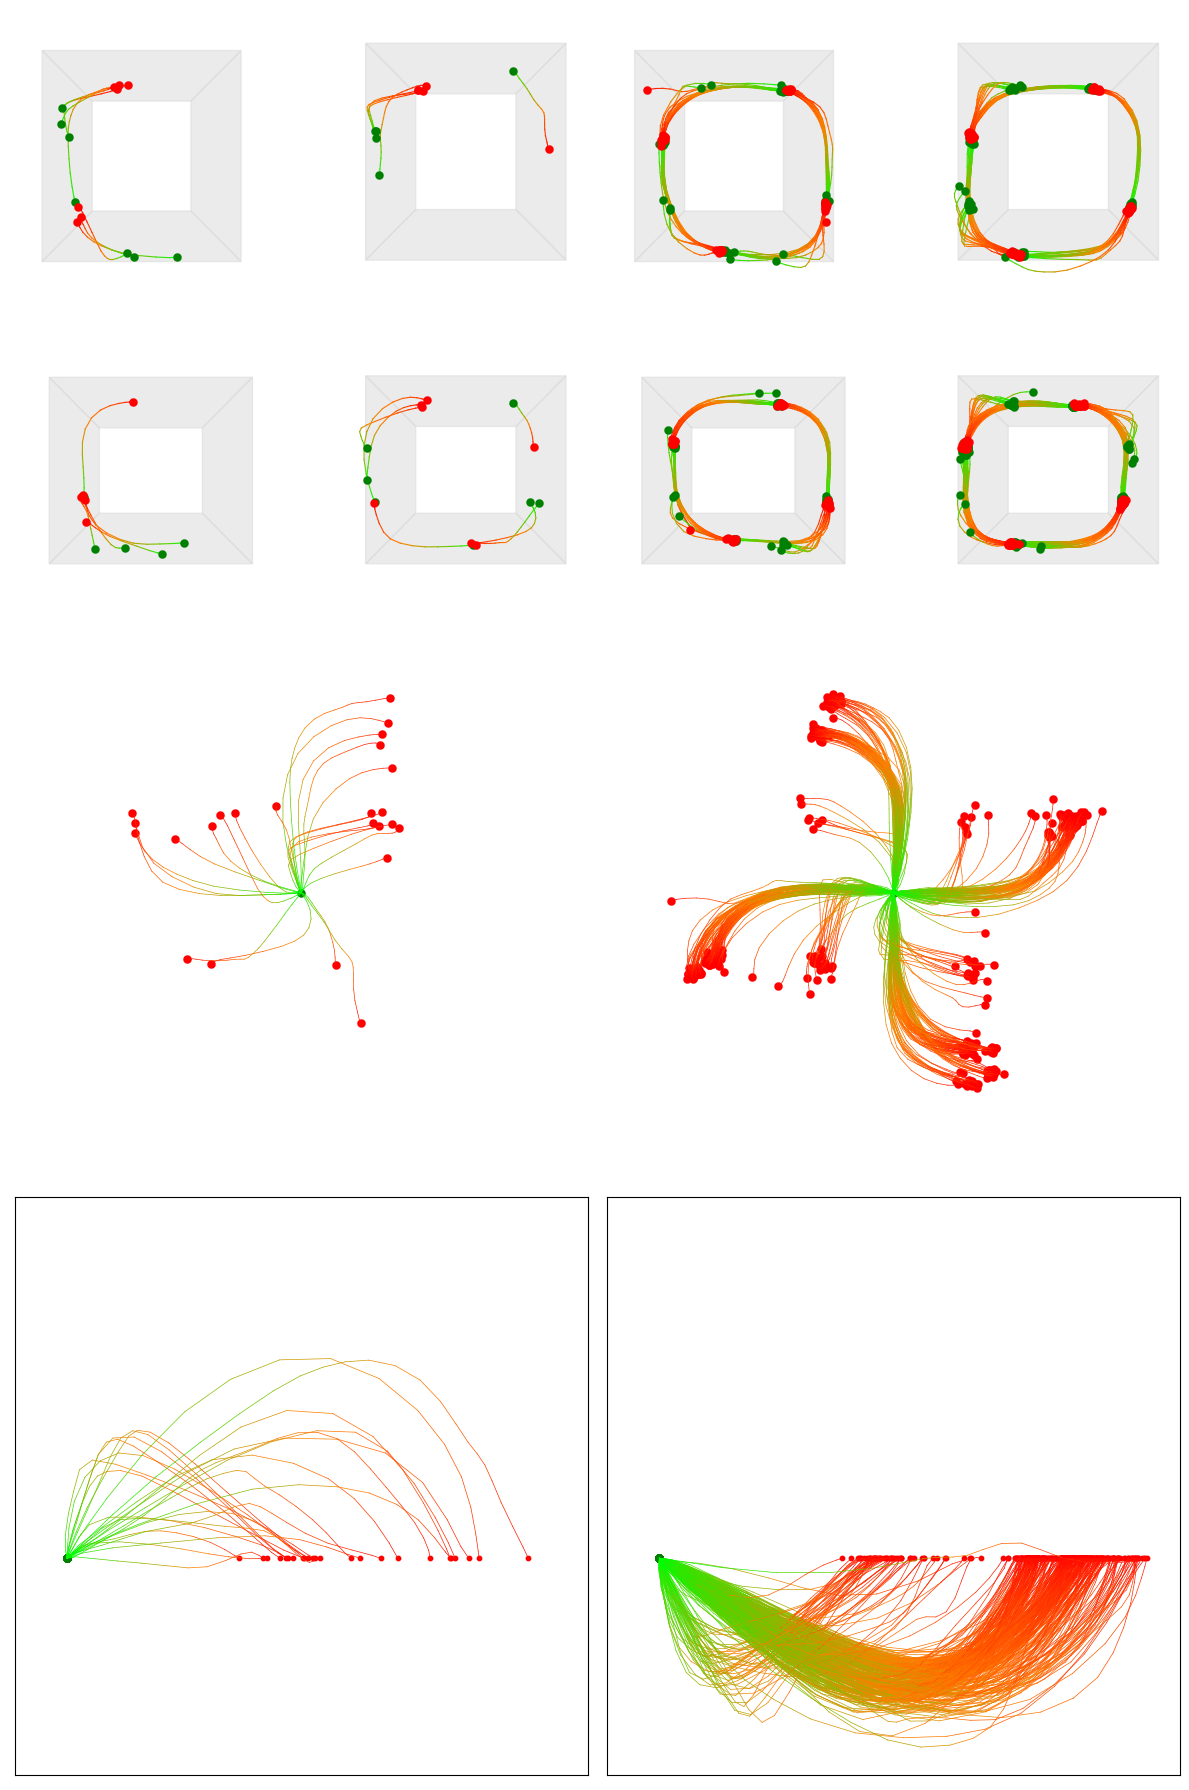

In [7]:
session_folder = mouseFolder_Path + '/' + session 

fig, axs = plt.subplots(3, 2, figsize=(12, 18))  # Ajusté pour trois lignes

# Clockwise turns
figure_quarterturns_Maud(clock_turn, xgauss, ygauss, collection_trapeze, ax1=axs[0, 0])
figure_quarterturns_inter(clock_turn, xgauss, ygauss, ax1=axs[1, 0])
figure_quarterturns_all(clock_turn, xgauss, ygauss, ax1=axs[2, 0])

# Counterclockwise turns
figure_quarterturns_Maud(anti_clock_turn, xgauss, ygauss, collection_trapeze, ax1=axs[0, 1])
figure_quarterturns_inter(anti_clock_turn, xgauss, ygauss, ax1=axs[1, 1])
figure_quarterturns_all(anti_clock_turn, xgauss, ygauss, ax1=axs[2, 1])

plt.tight_layout()

# Save the figure
#output_file = os.path.join(session_folder, 'quarter_turns.png')
#fig.savefig(output_file, format='png')

plt.show()

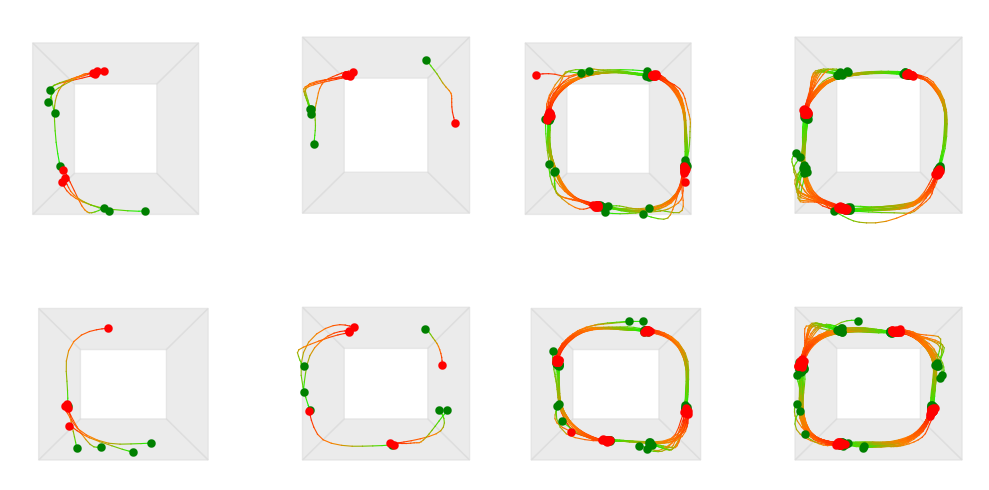

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Ajusté pour une seule ligne

# Clockwise turns
figure_quarterturns_Maud(clock_turn, xgauss, ygauss, collection_trapeze, ax1=axs[0])

# Counterclockwise turns
figure_quarterturns_Maud(anti_clock_turn, xgauss, ygauss, collection_trapeze, ax1=axs[1])

plt.tight_layout()

# Enregistrer la figure contenant uniquement la première ligne
#output_file = os.path.join(session_folder, 'quarter_turns_first_line.png')
#fig.savefig(output_file, format='png')

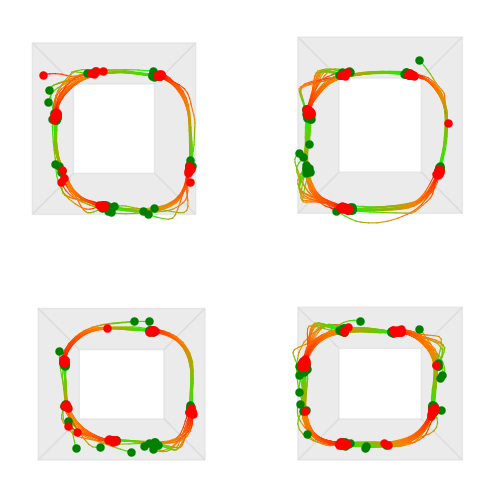

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))  # Ajusté pour une seule ligne

# Clockwise turns
figure_quarterturns_Maud(list_quarter_turn, xgauss, ygauss, collection_trapeze, ax1=ax)

plt.tight_layout()

# Enregistrer la figure contenant uniquement la première ligne
#output_file = os.path.join(session_folder, 'quarter_turns_first_line.png')
#fig.savefig(output_file, format='png')

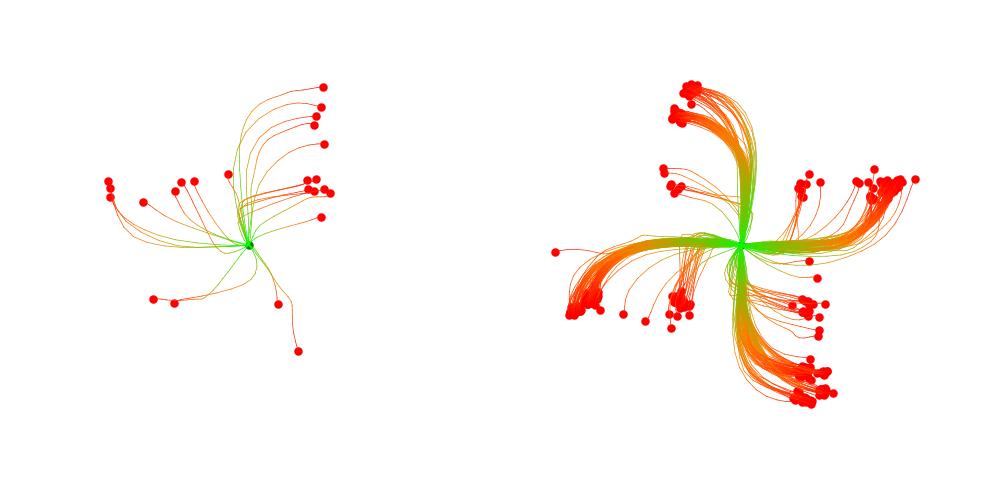

In [10]:
# Créez la nouvelle figure pour la deuxième ligne uniquement
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Ajusté pour une seule ligne

# Clockwise turns (Inter)
figure_quarterturns_inter(clock_turn, xgauss, ygauss, ax1=axs[0])

# Counterclockwise turns (Inter)
figure_quarterturns_inter(anti_clock_turn, xgauss, ygauss, ax1=axs[1])

plt.tight_layout()

# Enregistrer la figure contenant uniquement la deuxième ligne
#output_file = os.path.join(session_folder, 'quarter_turns_second_line.png')
#fig.savefig(output_file, format='png')

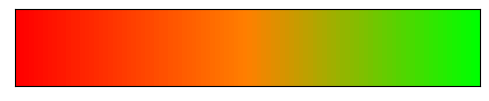

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Définition des couleurs pour le colormap (vert, orange, rouge)
colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)]  # Vert à Orange à Rouge

# Création du colormap personnalisé avec trois couleurs
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Exemple d'utilisation du colormap pour obtenir des couleurs
num_points = 100
colors = [cmap(1 - i / (num_points - 1)) for i in range(num_points)]

# Affichage des couleurs obtenues
fig, ax = plt.subplots(figsize=(6, 1))
ax.imshow([colors], aspect='auto')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


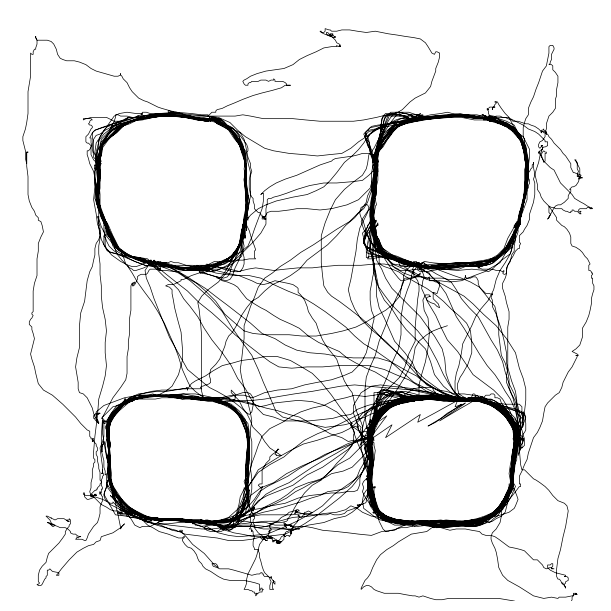

In [11]:
# Trajectory of entire session (crop)

def trajectories_and_speed(session, ax=None):
    csvCentroid_fullpath = mouseFolder_Path + '/' + session + '/' + session + '_centroidTXY.csv'
    df = pd.read_csv(csvCentroid_fullpath)
    df = df.dropna()
    df = df.loc[df['time'] > 15]
    df = df[df['xposition'].between(1, 500) & df['yposition'].between(1, 500)]

    xpositions = df['xposition'].to_numpy()
    ypositions = df['yposition'].to_numpy()

    distances = np.array([((((xpositions[i] - xpositions[i - 1]) ** 2) + ((ypositions[i - 1] - ypositions[i]) ** 2)) ** 0.5) for i in range(1, len(ypositions))])
    resolution = 512, 512

    df['yposition'] = resolution[1] - df['yposition']

    distances = distances * (0.84 / resolution[0])  # convert distance to m with apparatus length = 84 cm
    timeofframes = df['time'].to_numpy()
    timebeweenframe = np.diff(timeofframes)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

    df.plot(x='xposition', y='yposition', linewidth=0.5, ax=ax, c='k')
    ax.set_xlim(20, 480)
    ax.set_ylim(20, 480)
    ax.get_legend().remove()
    ax.axis('off')

trajectories_and_speed(session=session)

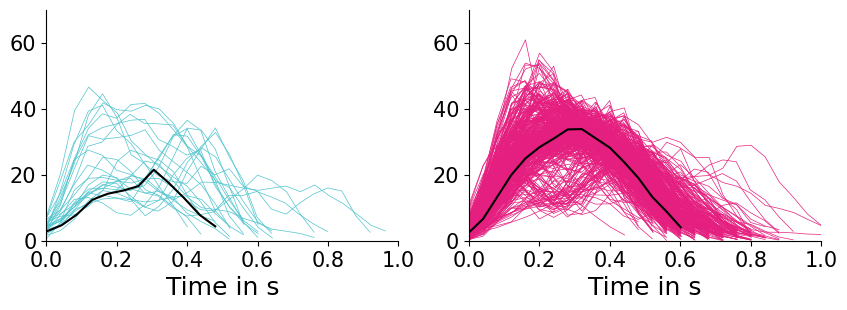

In [13]:
# Function to speed profiles

def plot_speed_profiles(time_average, speed, clock_turn, anti_clock_turn, ax1=None, ax2=None):
    if ax1 is None or ax2 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    # Définissez les couleurs pour chaque direction
    colors = ["#4ec4cd", "#e51f7f"]

    for a, ax in enumerate([ax1, ax2]):
        direction = ["clockwise", "counterclockwise"][a]

        # Trace le profil individuel de la vitesse de chaque quart de tour
        for u in [clock_turn, anti_clock_turn][a]:
            ax.plot(time_average[u[0]: u[1] + 1] - time_average[u[0]], 
                    speed[u[0]: u[1] + 1], linewidth=0.5, c=colors[a])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 70)
        if len([clock_turn, anti_clock_turn][a]) != 0:
            xmed, ymed = compute_median_trajectory(
                [speed[u[0]: u[1] + 1] for u in [clock_turn, anti_clock_turn][a]], 
                [time_average[u[0]: u[1] + 1] for u in [clock_turn, anti_clock_turn][a]]
            )
            ax.plot(xmed, ymed, c='black', linewidth=1.5)  # Trace la médiane en noir et plus épais
        ax.set_xlabel("Time in s", fontsize=18)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=15)
    #ax1.set_ylabel("Speed in cm/s", fontsize=18)

plot_speed_profiles(time_average, speed, clock_turn, anti_clock_turn)

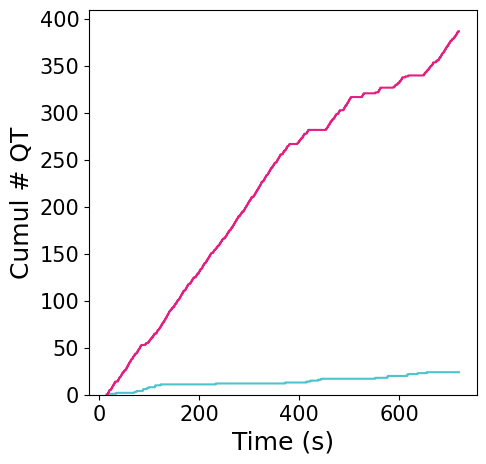

In [14]:
def figure_cumul_qturns(list_quarter_turn, time_average, axs=None):
    if axs is None:
        _, ax1 = plt.subplots(figsize=(5, 5))
    else:
        ax1 = axs

    # Compute the cumulative sums in accordance to time
    clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "w"]
    anti_clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "k"]
    clockcum = np.cumsum([1 if indice in [u[0] for u in clock_turn] else 0 for indice in range(len(time_average))])
    anticum = np.cumsum([1 if indice in [u[0] for u in anti_clock_turn] else 0 for indice in range(len(time_average))])

    # Plot the cumulative sum of each direction of QT
    ax1.plot(time_average, clockcum, c='#4ec4cd', label="CW")
    ax1.plot(time_average, anticum, c='#e51f7f', label="CCW")
    ax1.set_ylabel("Cumul # QT", fontsize=18)
    ax1.set_xlabel("Time (s)", fontsize=18)
    ax1.set_ylim(0, 410)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    #ax1.legend()

# Example usage:
figure_cumul_qturns(list_quarter_turn, time_average)


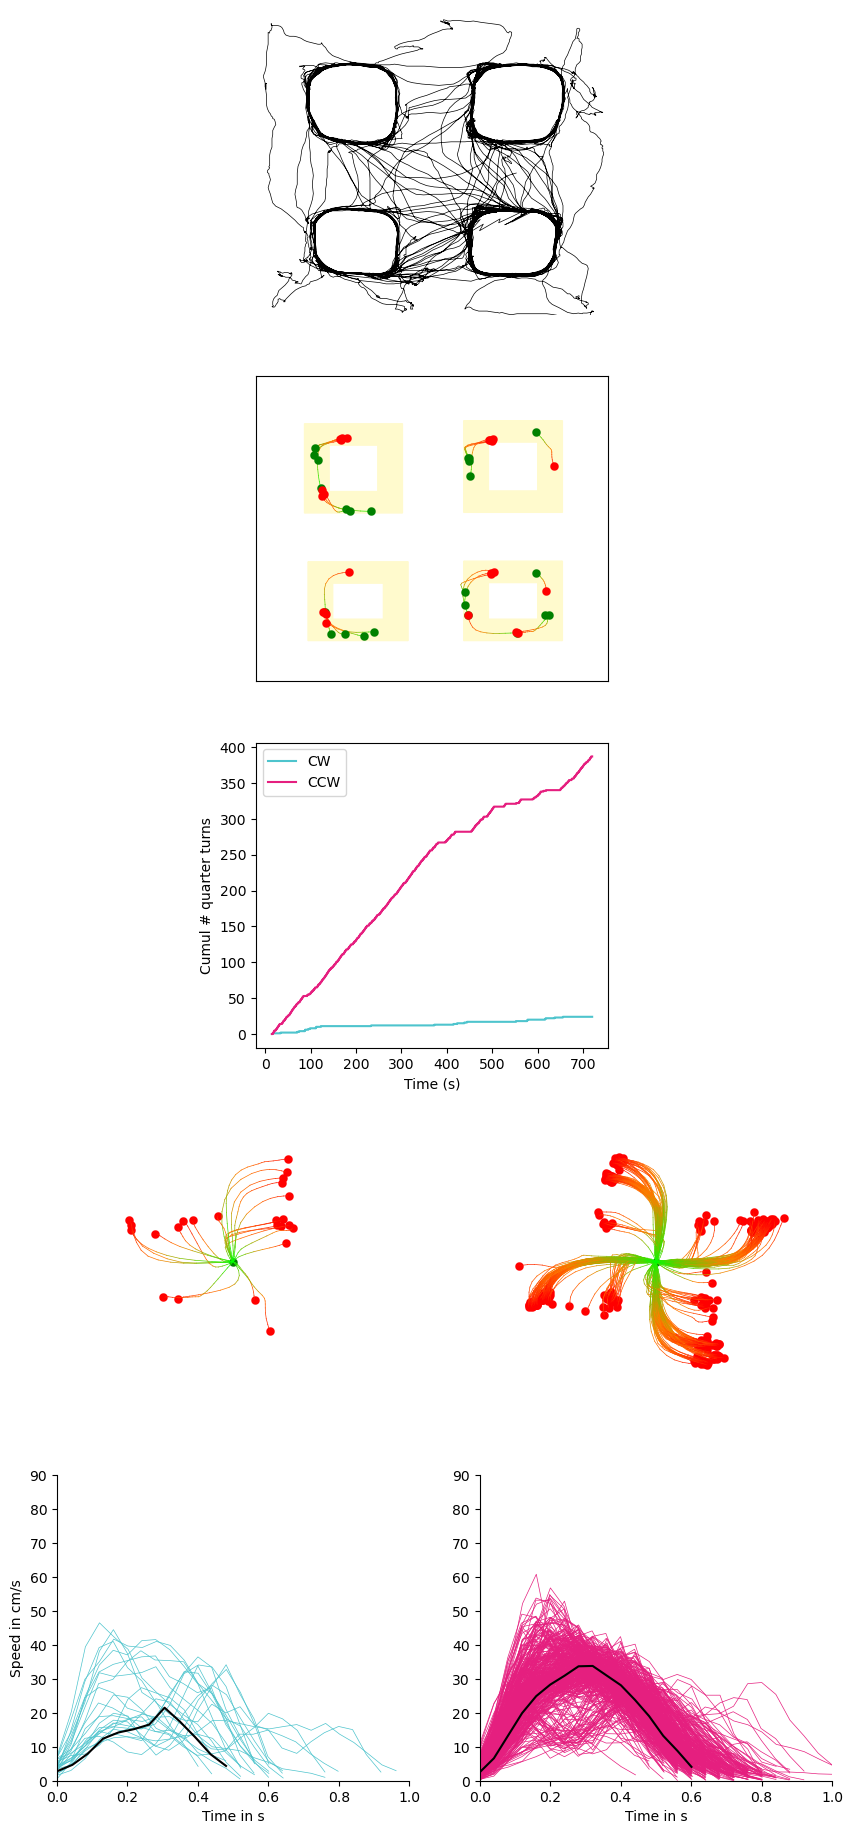

In [239]:
# Crée la figure principale avec une grille de 2 colonnes et 5 lignes
fig, axs = plt.subplots(5, 2, figsize=(10, 23))

# Première ligne : trajectories_and_speed
trajectories_and_speed(session, ax=axs[0, 0])

axs[0, 1].remove()

# Deuxième ligne : figure_quarterturns_Maud
figure_quarterturns_Maud(clock_turn, xgauss, ygauss, collection_trapeze, ax1=axs[1, 0])

axs[1, 1].remove()

# Troisième ligne : figure_cumul_qturns
figure_cumul_qturns(list_quarter_turn, time_average, axs=axs[2, 0])

axs[2, 1].remove()

# Ajuster la position horizontale pour centrer les subplots des trois premières lignes
for row in range(3):
    axs[row, 0].set_position([0.5 - axs[row, 0].get_position().width / 2, axs[row, 0].get_position().y0,
                              axs[row, 0].get_position().width, axs[row, 0].get_position().height])


# Quatrième ligne : figure_quarterturns_inter (clock_turn et anti_clock_turn)
figure_quarterturns_inter(clock_turn, xgauss, ygauss, ax1=axs[3, 0])
figure_quarterturns_inter(anti_clock_turn, xgauss, ygauss, ax1=axs[3, 1])

# Cinquième ligne : plot_speed_profiles (clock_turn et anti_clock_turn)
plot_speed_profiles(time_average, speed, clock_turn, anti_clock_turn, ax1=axs[4, 0], ax2=axs[4, 1])

plt.show()


In [357]:
def process_session(mouseFolder_Path, session, axs, col_start):
    # Load data
    traj_df, turns_df, param_df = load_data(mouseFolder_Path, session)
    phase, direction, cno = get_phase_direction_cno(param_df)

    time = traj_df['time'].to_numpy()
    xposition = traj_df['xposition'].to_numpy()
    yposition = traj_df['yposition'].to_numpy()
    yposition = RESOLUTION[1] - yposition  # yposition is inverted, puts it back in the right way
    xgauss = smooth(xposition, TRUE_SIGMA)
    ygauss = smooth(yposition, TRUE_SIGMA)  # Smoothes the positions with true sigma

    distance, speed, time_average, acceleration, angles, angular_speed, list_epochs = analysis_trajectory(
        time, xgauss, ygauss, collection_trapeze, turns_df, TRUE_CUT_SPEED, TRUE_ECART_ANGLE, RESOLUTION,
        MIN_DURATION_EPOCH=MINIMAL_DURATION_EPOCH, MIN_DURATION_STOP=MINIMAL_DURATION_STOP)

    stops_type = {"rewarded": [], "unrewarded": []}
    for i in range(len(list_epochs) - 1):
        if list_epochs[i][2][0] == "Q":  # If this is a quarter turn
            if list_epochs[i][2][2] == "G":  # If this is a good turn and thus a rewarded quarter turn
                stops_type["rewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
            else:  # Then the quarter turn was not rewarded
                stops_type["unrewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])

    list_quarter_turn = [epoch for epoch in list_epochs if epoch[2][0] == "Q"]  # Gets the list of all quarter turns
    list_between_objects = [epoch for epoch in list_epochs if epoch[2][0] == "B"]  # Gets all trajectories between objects

    rewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'G']
    badDirection = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'B']

    anti_clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "k"]
    clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "w"]

    # Plotting for the current session
    # First row: trajectories_and_speed
    trajectories_and_speed(session, ax=axs[0, col_start])
    axs[0, col_start + 1].remove()

    # Second row: figure_quarterturns_Maud
    figure_quarterturns_Maud(clock_turn, xgauss, ygauss, collection_trapeze, ax1=axs[1, col_start])
    axs[1, col_start + 1].remove()

    # Third row: figure_cumul_qturns
    figure_cumul_qturns(list_quarter_turn, time_average, axs=axs[2, col_start])
    axs[2, col_start + 1].remove()

    # Fourth row: figure_quarterturns_inter (clock_turn and anti_clock_turn)
    figure_quarterturns_inter(clock_turn, xgauss, ygauss, ax1=axs[3, col_start])
    figure_quarterturns_inter(anti_clock_turn, xgauss, ygauss, ax1=axs[3, col_start + 1])

    # Fifth row: plot_speed_profiles (clock_turn and anti_clock_turn)
    plot_speed_profiles(time_average, speed, clock_turn, anti_clock_turn, ax1=axs[4, col_start], ax2=axs[4, col_start + 1])

    # Adjust positions for rows 1 to 3
    for row in range(3):
        pos = axs[row, col_start].get_position()
        new_x0 = pos.x0 + pos.width / 2  # Shift left edge to the center of the current column
        axs[row, col_start].set_position([new_x0, pos.y0, pos.width, pos.height])


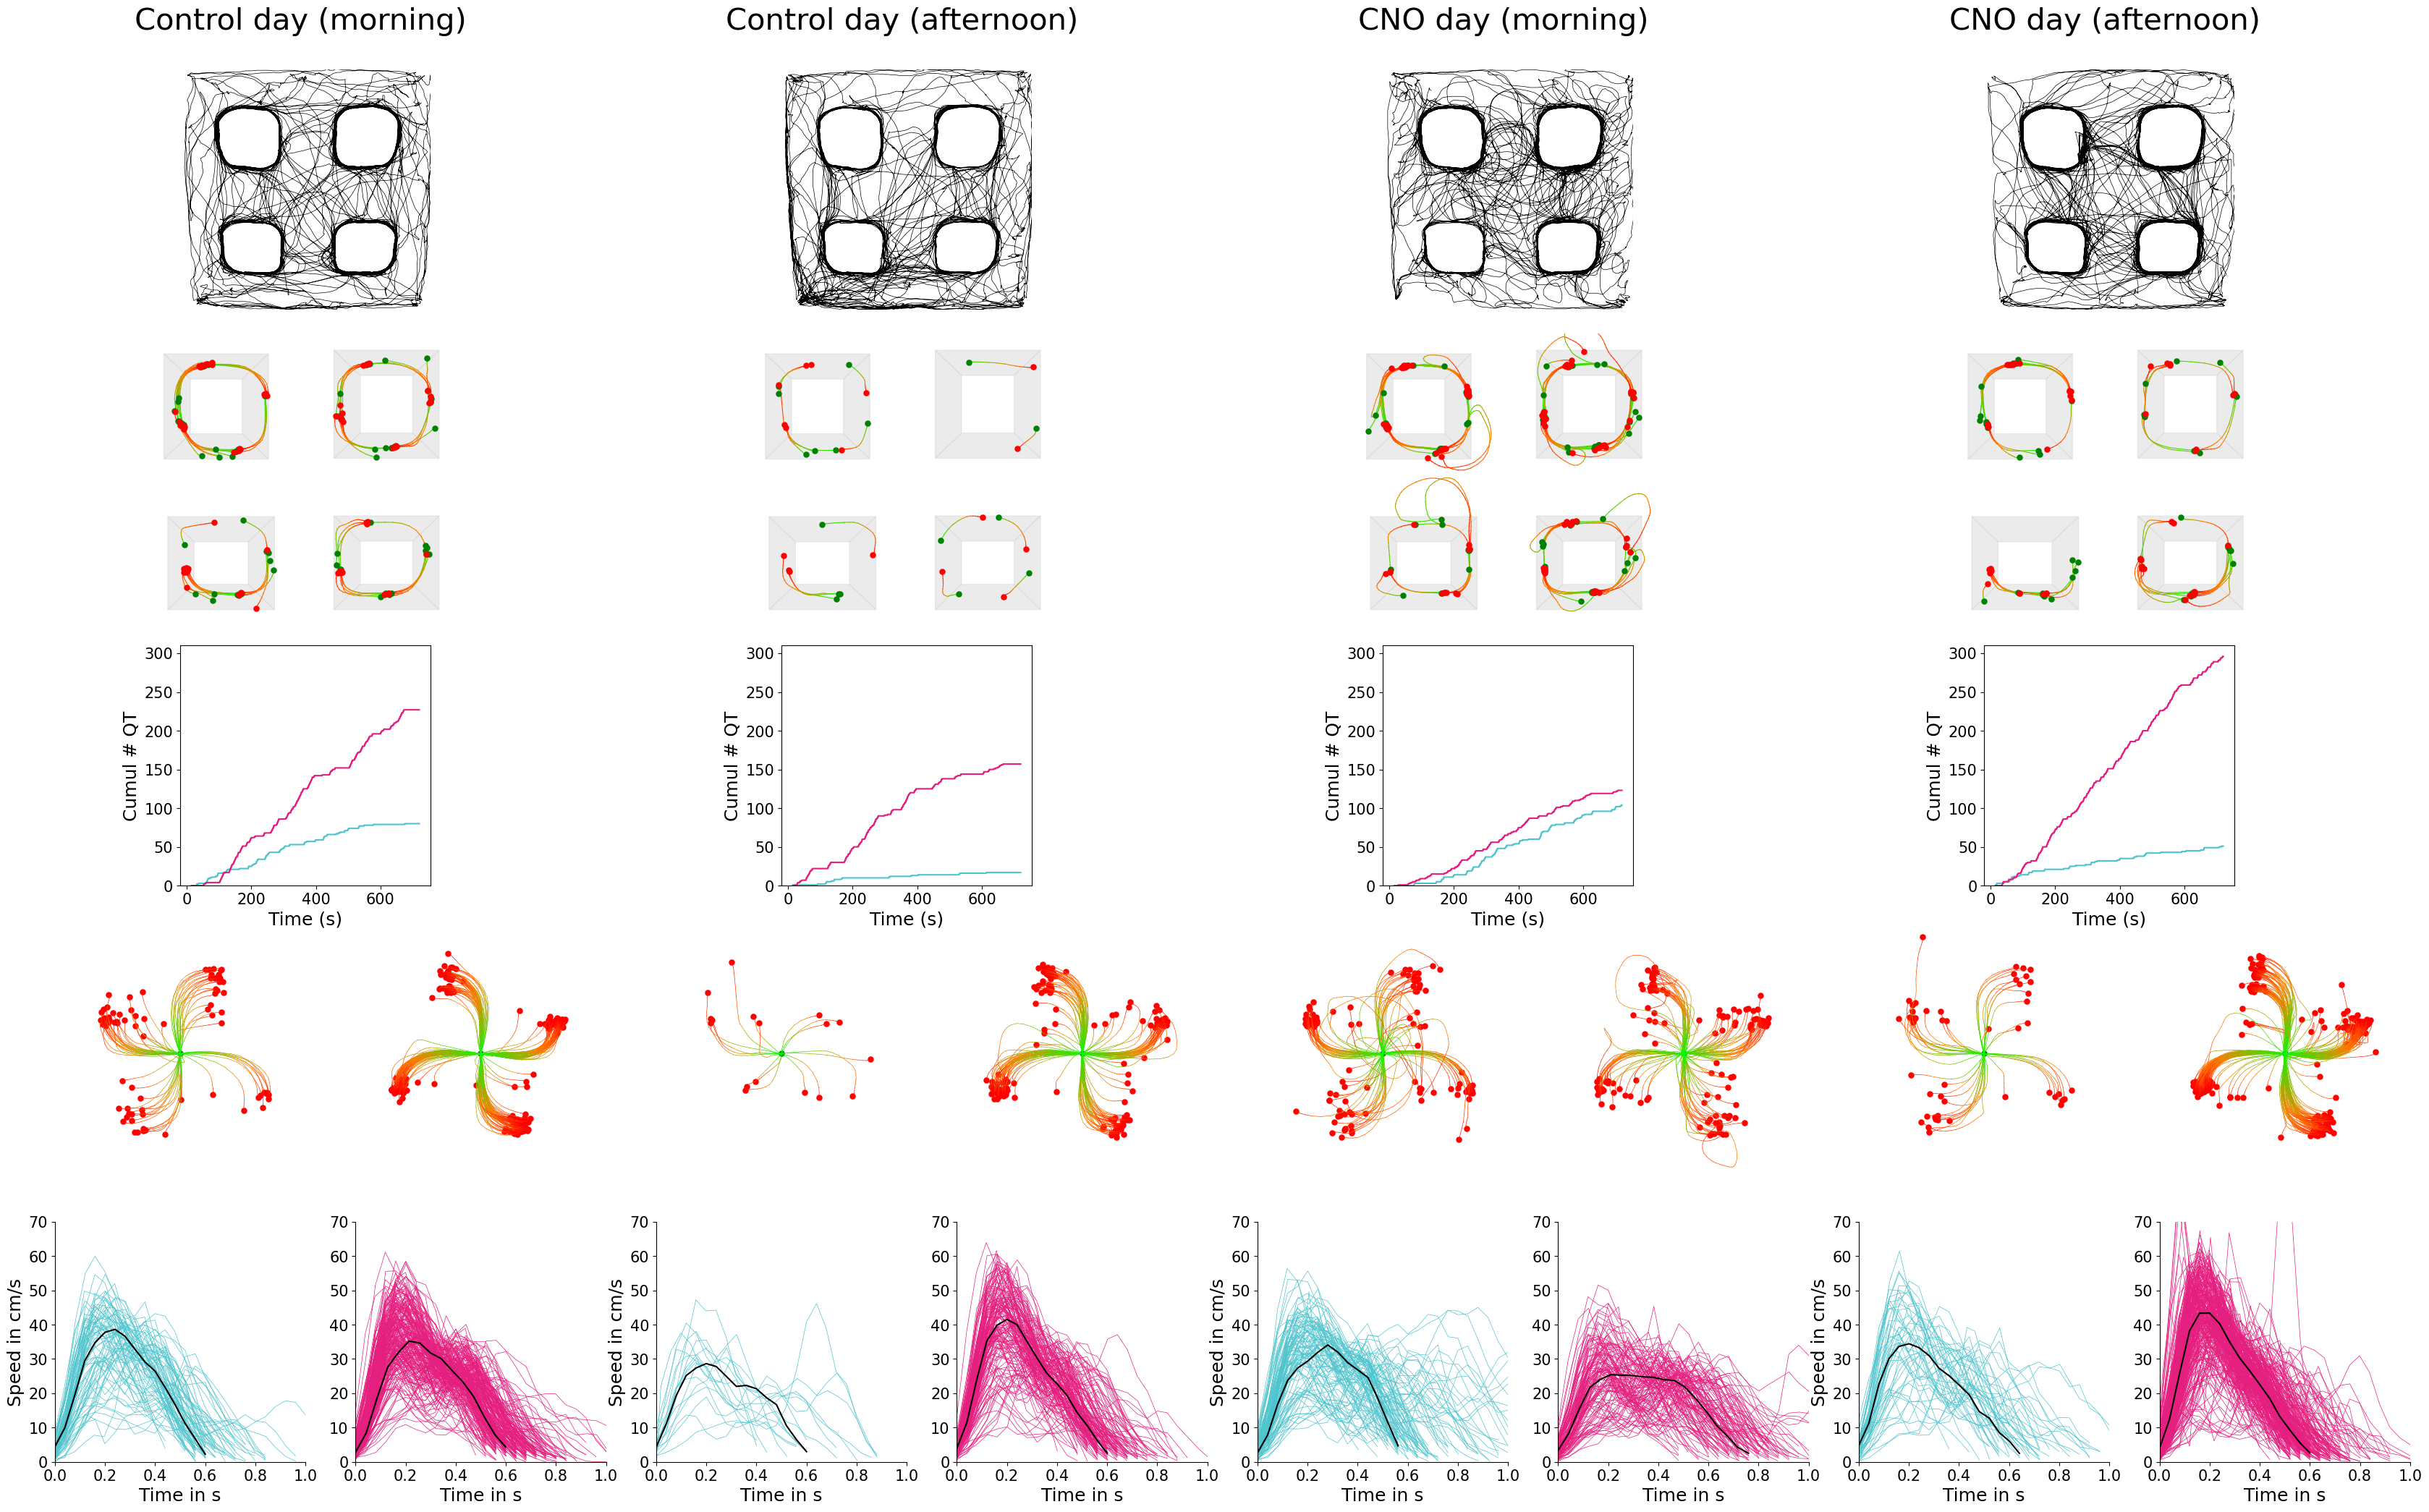

In [367]:
# Define the sessions
sessions = ['MOU4175_20230718-1115', 'MOU4175_20230718-1631', 'MOU4175_20230720-1154', 'MOU4175_20230720-1733']
mouse = 'MOU4175'
mouseFolder_Path = root + mouse

# Create the main figure with a grid of 8 columns (2 per session) and 5 rows
fig, axs = plt.subplots(5, 8, figsize=(42, 25))

# Process each session and plot
for i, session in enumerate(sessions):
    process_session(mouseFolder_Path, session, axs, i * 2)

#plt.subplots_adjust(hspace=0.5, wspace=0.2)  # Ajuste l'espacement vertical et horizontal entre les sous-graphiques

# Ajustement de la taille des subplots dans la deuxième ligne uniquement
for col_start in [0, 2, 4, 6]:
    pos0 = axs[0, col_start].get_position()  # Position du subplot dans la ligne 0
    pos1 = axs[1, col_start].get_position()  # Position du subplot dans la ligne 1
    new_bottom = pos0.y0 - pos1.height - 0.04  # Nouvelle position basse pour le subplot de la ligne 1
    new_left = pos1.x0 - 0.01  # Décalage vers la gauche
    axs[1, col_start].set_position([new_left, new_bottom, pos1.width * 1.2, pos1.height * 1.2])


# Titres spécifiques pour chaque colonne
axs[0, 0].set_title("Control day (morning) \n", fontsize=30)
axs[0, 2].set_title("Control day (afternoon) \n", fontsize=30)
axs[0, 4].set_title("CNO day (morning) \n", fontsize=30)
axs[0, 6].set_title("CNO day (afternoon) \n", fontsize=30)

# Display the figure
plt.show()